In [1]:
from utils import transform
from PIL import Image

# Использование

(1080, 1080)


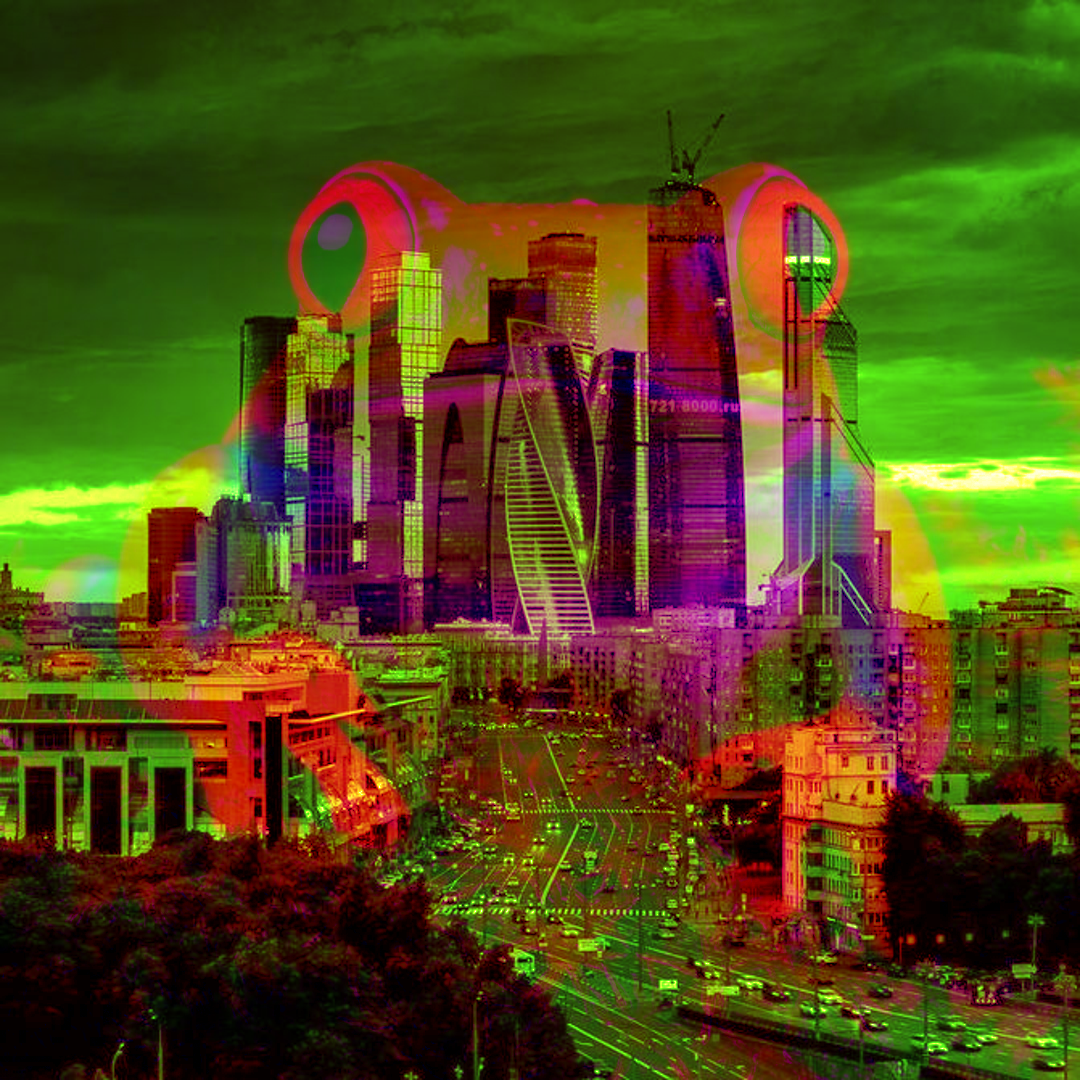

In [3]:
transform('frog.png')

In [235]:
gs = [0.2126, 0.7152, 0.0722]
# gs = [0.299, 0.587, 0.114]

In [121]:
# secret = Image.fromarray(np.random.randint(0, 255, (*source.size[::-1], 3), dtype='uint8'))

In [145]:
np.array(source).mean(axis=(0, 1)) @ np.array(gs) / 255

0.2978583780527986

In [241]:
%%time

hided = hide(source, 0.1)
# hide(source, secret)
# hide(secret, source)

CPU times: user 3.17 s, sys: 1.79 s, total: 4.95 s
Wall time: 5.94 s


In [136]:
%%time

frames = []
for i in range(256):
    img = hide(source.resize((200, 200)), i / 255)
    frames.append(img)
    img.save(f'output/frame_{i:03}.png')
    print(f'\r{round(i/255*100, 2)}%', end='')
print()

100.0%
CPU times: user 1min 10s, sys: 7.54 s, total: 1min 17s
Wall time: 1min 41s


In [244]:
%%time

imgs = []
n = 50
img = source.resize((200, 200))

for i in range(n):
    imgs.append(hide(img.filter(ImageFilter.GaussianBlur(i / (n-1) * 100)), 
                     img, ))
    print(f'\r{round(i/(n-1)*100, 2)}%', end='')
print()
imgs[0].save(f'output/test/blur.gif', 
             save_all=True, 
             append_images=imgs[1:], 
             duration=100)

100.0%
CPU times: user 9.09 s, sys: 1.1 s, total: 10.2 s
Wall time: 10.4 s


In [139]:
frames[0].save(f'output/test.gif', 
               save_all=True, 
               append_images=frames[1:], 
               duration=20)

In [88]:
# source = source.convert('RGBA')
# draw = ImageDraw.Draw(source)
# font = ImageFont.truetype('Arial.ttf', 100)
# W, H = source.size
# message='Hello world'
# _, _, w, h = draw.textbbox((0, 0), message, font=font)
# draw.text(((W-w)/2, (H-h)/2), message, font=font, fill=(255, 0, 255, 50))
# source

CPU times: user 1.16 s, sys: 468 ms, total: 1.63 s
Wall time: 1.65 s


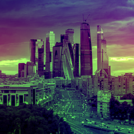

In [247]:
%%time

img = hide(
    source.filter(ImageFilter.GaussianBlur(100)), 
    source, 
    gs
)
img.resize(np.round(np.array(img.size) * 0.2).astype(int))

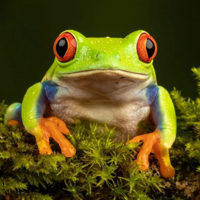

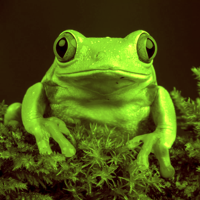

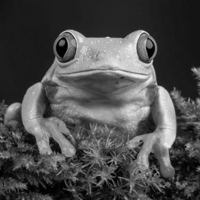

In [152]:
display(source.resize((200, 200)))
display(img.resize((200, 200)))
display(img.convert('L').resize((200, 200)))